In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from solution import cost_function, Model


In [38]:
test_x = pd.read_csv("test_x.csv")
train = pd.concat([pd.read_csv("train_x.csv"), pd.read_csv("train_y.csv")], axis=1)
print(train.shape)
np.random.seed(100)


(15189, 3)


In [3]:
from sklearn import model_selection

train_x, val_x, train_y, val_y = model_selection.train_test_split(
    train[["lat", "lon"]].values, train[["pm25"]].values, test_size=0.2
)


In [4]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    DotProduct,
    WhiteKernel,
    RBF,
    Sum,
    Matern,
    Product,
    ConstantKernel,
)

kernel1 = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel2 = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(
    noise_level=5e-2
)
gpr1 = GaussianProcessRegressor(kernel=kernel1, normalize_y=True, random_state=0)
gpr2 = GaussianProcessRegressor(kernel=kernel2, normalize_y=True, random_state=0)
gpr3 = GaussianProcessRegressor(
    kernel=Product(kernel1, kernel2), alpha=1e-3, normalize_y=True, random_state=0
)


In [5]:
(lat_low_1, lat_high_1, lon_low_1, lon_high_1) = (0,1.0,0.0,0.2)
(lat_low_2, lat_high_2, lon_low_2, lon_high_2) = (0,1.0,0.2,0.6)
(lat_low_3, lat_high_3, lon_low_3, lon_high_3) = (0,1.0,0.6,1.0)
region_1 = (lat_low_1, lat_high_1, lon_low_1, lon_high_1)
region_2 = (lat_low_2, lat_high_2, lon_low_2, lon_high_2)
region_3 = (lat_low_3, lat_high_3, lon_low_3, lon_high_3)
region_to_gp = {
    # (x1,lon_low,x2,y2): gpr_region1
    region_1: region_1,
    region_2: region_2,
    region_3: region_3,
}


In [6]:
def get_region_mask(data, region_bounds):
    return ((region_bounds[0] <= data[:, 0])
            & (data[:, 0] < region_bounds[1])
            & (region_bounds[2] <= data[:, 1])
            & (data[:, 1] < region_bounds[3]))

In [7]:
xs=[train_x[get_region_mask(train_x, r)] for r in [region_1, region_2, region_3, ]]
train_x.shape, [x.shape for x in xs]

((12151, 2), [(2207, 2), (5649, 2), (4295, 2)])

In [82]:

gprs = []
region_masks_val=[]
preds_val=[]
preds_val_stats=[]
for region in [region_1, region_2, region_3, ]:
    region_mask_train = get_region_mask(train_x, region)
    features_train = train_x[
        region_mask_train
    ][:2000]
    labels_train=train_y[region_mask_train][:2000]
    gpr = GaussianProcessRegressor(
    kernel=Product(kernel1, kernel2), alpha=1e-3, normalize_y=True, random_state=0
)
    gpr.fit(features_train, labels_train)
    gprs.append(gpr)

    region_mask_val = get_region_mask(val_x, region)
    features_val=val_x[region_mask_val]
    labels_val=val_y[region_mask_val]
    val_pred_mean, val_pred_std = gpr.predict(features_val, return_std=True)
    val_pred = val_pred_mean
    print(cost_function(labels_val.squeeze(), val_pred.squeeze()))
    region_masks_val.append(region_mask_val)
    preds_val.append(val_pred)
    preds_val_stats.append([val_pred_mean, val_pred_std])

51.682251846940346


/home/master/.conda/envs/sc/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


83.72203000145839
79.21719234944007


In [83]:
final_val_pred = np.zeros_like(val_y)
preds_val_stats_final = np.zeros(shape=(len(val_y), 2))
for region_mask, pred_val, pred_val_stats in zip(region_masks_val, preds_val, preds_val_stats):
    final_val_pred[region_mask] = pred_val[:,np.newaxis]
    preds_val_stats_final[region_mask] = np.array(pred_val_stats).T

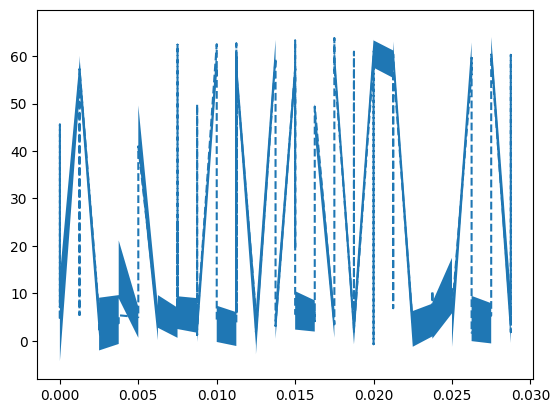

In [84]:
feature_idx=1
idxs = np.argsort(val_x[:, feature_idx])[:100]
plt.plot(val_x[idxs, feature_idx], val_y[idxs], "--")
plt.gca().fill_between(
    val_x[idxs, feature_idx],
    preds_val_stats_final[idxs, 0] - 1.96 * preds_val_stats_final[idxs, 1],
    preds_val_stats_final[idxs, 0] + 1.96 * preds_val_stats_final[idxs, 1],
)


In [85]:
import scipy
val_mean, val_std = preds_val_stats_final[:, 0].copy(), preds_val_stats_final[:, 1].copy()
val_pred=val_mean[:]
print(f"RAW loss: {cost_function(val_y.squeeze(), val_pred.squeeze())}")
print(scipy.stats.describe(val_pred))
big_unc_mask = val_std > np.quantile(val_std, 0.8)
avg_unc_mask = (val_std > np.quantile(val_std, 0.3)) & (val_std < np.quantile(val_std, 0.7))
mild_unc_mask = val_std < np.quantile(val_std, 0.2)
val_pred[big_unc_mask] += 0.15*val_std[big_unc_mask]
val_pred[avg_unc_mask] += 0.5*val_std[avg_unc_mask]
val_pred[mild_unc_mask] += 1*val_std[mild_unc_mask]
print(scipy.stats.describe(val_pred))
print(f"Shifted mean loss: {cost_function(val_y.squeeze(), val_pred.squeeze())}")


RAW loss: 75.77282720200861
DescribeResult(nobs=3038, minmax=(-1.7556764789452117, 63.39342151113679), mean=33.10768713816092, variance=340.2921192226919, skewness=-0.16788212639319217, kurtosis=-1.3486476362695454)
DescribeResult(nobs=3038, minmax=(-0.7273557924534435, 64.85385352516734), mean=33.925377540422915, variance=345.6848448517399, skewness=-0.1598269456711749, kurtosis=-1.352574624315702)
Shifted mean loss: 62.00137989817695


In [94]:
val_mean, val_std = preds_val_stats_final[:, 0].copy(), preds_val_stats_final[:, 1].copy()
pred_mask = big_unc_mask | mild_unc_mask
def black_box_function(coef_big_std, coef_avg_std, coef_small_std, q_big_unc_mask,
q_avg_unc_mask_low,
q_avg_unc_mask_high,
q_small_unc_mask,):
    big_unc_mask = val_std > np.quantile(val_std, q_big_unc_mask)
    avg_unc_mask = (val_std > np.quantile(val_std, q_avg_unc_mask_low)) & (val_std < np.quantile(val_std, q_avg_unc_mask_high))
    mild_unc_mask = val_std < np.quantile(val_std, q_small_unc_mask)
    val_pred=val_mean.copy()
    # pred_mask = True
    val_pred[big_unc_mask] += coef_big_std*val_std[big_unc_mask]
    val_pred[avg_unc_mask] += coef_avg_std*val_std[avg_unc_mask]
    val_pred[mild_unc_mask] += coef_small_std*val_std[mild_unc_mask]
    score = cost_function(val_y.squeeze(), val_pred.squeeze())
    return -score

|   iter    |  target   | coef_a... | coef_b... | coef_s... | q_avg_... | q_avg_... | q_big_... | q_smal... |
-------------------------------------------------------------------------------------------------------------
| 2         | -68.53    | 0.3456    | 0.3968    | 0.5388    | 0.6258    | 0.4056    | 0.8409    | 0.1768    |
| 9         | -63.23    | 0.5741    | 0.1467    | 0.5893    | 0.7099    | 0.2307    | 0.8828    | 0.1419    |
| 13        | -61.81    | 0.5688    | 0.3207    | 1.0       | 0.8       | 0.2       | 1.0       | 0.2       |
| 21        | -59.27    | 0.5828    | 0.2009    | 0.8078    | 0.8       | 0.2       | 0.8       | 0.2       |
| 28        | -58.97    | 0.5186    | 0.2443    | 1.0       | 0.8       | 0.2       | 0.8       | 0.2       |
Best result: {'coef_avg_std': 0.5185760986204269, 'coef_big_std': 0.2443434966375043, 'coef_small_std': 1.0, 'q_avg_unc_mask_high': 0.8, 'q_avg_unc_mask_low': 0.2, 'q_big_unc_mask': 0.8, 'q_small_unc_mask': 0.2}; f(x) = -58.970.


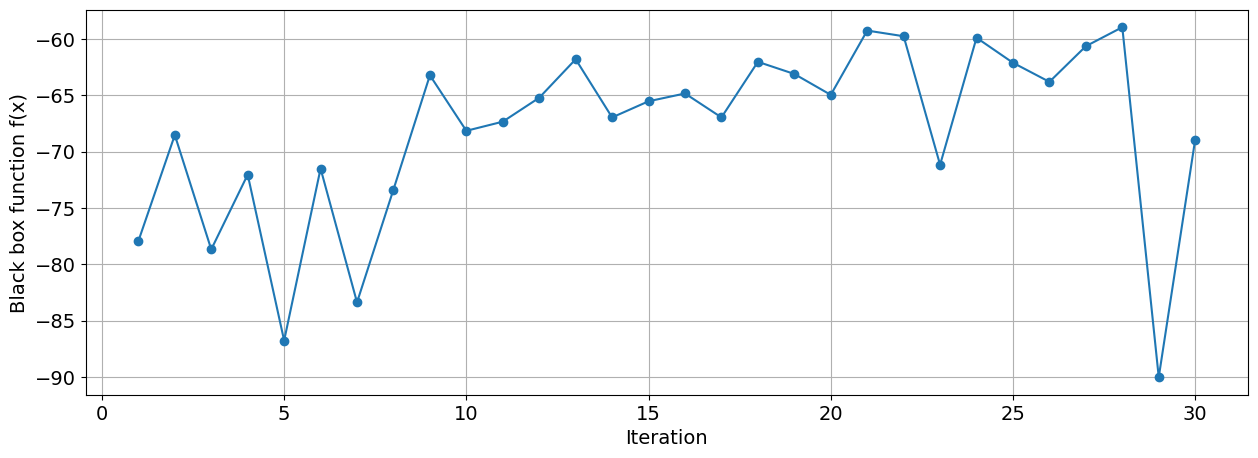

In [95]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'coef_big_std': (0, 1), 'coef_avg_std': (0, 1), 'coef_small_std': (0, 1),
'q_big_unc_mask': (0.8,1),
'q_avg_unc_mask_low': (0.2,0.5),
'q_avg_unc_mask_high': (0.5,0.8),
'q_small_unc_mask': (0.01,0.2),
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,verbose = 1,
    random_state=1,
)
result=optimizer.maximize(
    init_points=10,
    n_iter=20,
)
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [96]:
coef_avg_std=optimizer.max['params']['coef_avg_std']
coef_big_std=optimizer.max['params']['coef_big_std']
coef_small_std=optimizer.max['params']['coef_small_std']
q_big_unc_mask=optimizer.max['params']['q_big_unc_mask']
q_avg_unc_mask_low=optimizer.max['params']['q_avg_unc_mask_low']
q_avg_unc_mask_high=optimizer.max['params']['q_avg_unc_mask_high']
q_small_unc_mask=optimizer.max['params']['q_small_unc_mask']
val_mean, val_std = preds_val_stats_final[:, 0].copy(), preds_val_stats_final[:, 1].copy()
val_pred=val_mean[:]
print(f"RAW loss: {cost_function(val_y.squeeze(), val_pred.squeeze())}")
print(scipy.stats.describe(val_pred))
# val_pred[val_std>np.quantile(val_std, 0.7)]+=0.25*val_std[val_std>np.quantile(val_std, 0.7)]
big_unc_mask = val_std > np.quantile(val_std, q_big_unc_mask)
avg_unc_mask = (val_std > np.quantile(val_std, q_avg_unc_mask_low)) & (val_std < np.quantile(val_std, q_avg_unc_mask_high))
mild_unc_mask = val_std < np.quantile(val_std, q_small_unc_mask)
pred_mask = big_unc_mask | mild_unc_mask
val_pred[big_unc_mask] += coef_big_std*val_std[big_unc_mask]
val_pred[avg_unc_mask] += coef_avg_std*val_std[avg_unc_mask]
val_pred[mild_unc_mask] += coef_small_std*val_std[mild_unc_mask]
print(scipy.stats.describe(val_pred))
print(f"Shifted mean loss: {cost_function(val_y.squeeze(), val_pred.squeeze())}")

RAW loss: 75.77282720200861
DescribeResult(nobs=3038, minmax=(-1.7556764789452117, 63.39342151113679), mean=33.10768713816092, variance=340.2921192226919, skewness=-0.16788212639319217, kurtosis=-1.3486476362695454)
DescribeResult(nobs=3038, minmax=(-0.6891514194820512, 64.85385352516734), mean=34.235996634016104, variance=342.1500896303899, skewness=-0.16462834881899469, kurtosis=-1.3483737347502651)
Shifted mean loss: 58.969574751798504


In [100]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)
[signaltonoise(x) for r in [region_1, region_2, region_3] for x in [train.loc[get_region_mask(train.values, r), 'pm25'], train.loc[get_region_mask(train.values, r), 'lat'], train.loc[get_region_mask(train.values, r), 'lon']] ]

[array(1.25273009),
 array(1.72252036),
 array(1.56664357),
 array(1.64252744),
 array(3.35743293),
 array(1.57417521),
 array(2.48913143),
 array(7.61841976),
 array(1.79651146)]

Error analysis

In [203]:
errors = pd.DataFrame(val_y, columns=["pm25"]).copy()
errors["pm25_pred"] = val_pred
errors["pm25_pred_mean"] = preds_val_stats_final[:, 0]
errors["pm25_pred_std"] = preds_val_stats_final[:, 1]

In [204]:
errors["pred-lower-true"] = errors["pm25"] - errors["pm25_pred"] > 0
errors["slight-overpred"] = (errors["pm25"] <= errors["pm25_pred"]) & (
    errors["pm25_pred"] < errors["pm25"] * 1.01
)
errors["significant-overpred"] = errors["pm25"] * 1.01 <= errors["pm25_pred"]


In [205]:
errors[["pred-lower-true", "slight-overpred", "significant-overpred"]].apply(pd.value_counts)


,pred-lower-true,slight-overpred,significant-overpred
False,1836,2863,1377
True,1202,175,1661


In [206]:
errors['pred-lower-true'].sum()*25, errors['slight-overpred'].sum()*1+errors['significant-overpred'].sum()*10

(30050, 16785)

In [207]:
errors[errors["pred-lower-true"] != True]


,pm25,pm25_pred,pm25_pred_mean,pm25_pred_std,pred-lower-true,slight-overpred,significant-overpred
0,57.419974,58.430962,57.193084,1.237877,False,False,True
1,59.278039,60.239405,60.239405,2.523151,False,False,True
5,42.354821,45.109953,45.109953,1.993294,False,False,True
6,7.525017,18.278252,17.159070,7.461215,False,False,True
7,34.396187,36.529136,36.529136,2.498470,False,False,True
...,...,...,...,...,...,...,...
3027,10.846502,11.730106,10.706360,6.824972,False,False,True
3028,58.428852,61.282474,59.750649,1.531825,False,False,True
3034,32.099117,32.918629,32.274610,4.293459,False,False,True
3036,16.628116,25.558858,24.439957,7.459340,False,False,True
